# Ferromagnetism and Hysteresis

In the previous notebook, we looked at materials that respond linearly to a magnetic field. When the field is removed, the magnetization returns to zero. There is no "memory."

Now we turn to **Ferromagnetism (sensu lato)**. In rock magnetism, this broad category includes true ferromagnets (like native iron), ferrimagnets (like magnetite), and canted antiferromagnets (like hematite).

### The Critical Difference: Exchange Coupling
In diamagnets and paramagnets, atoms act independently. In ferromagnetic materials, quantum mechanical forces known as **exchange coupling** lock the magnetic moments of neighboring atoms together.

This creates broad regions called **magnetic domains** where spins are aligned. Because the spins want to stay aligned, these materials exhibit:
1.  **Spontaneous Magnetization:** They can be magnetized even without an external field.
2.  **Hysteresis:** The path of magnetization depends on the history of the applied field.

### The Hysteresis Loop

To describe a ferromagnetic rock, we trace a full cycle of applied fields. This traces out a loop that reveals three critical parameters:

#### 1. Saturation Magnetization ($M_s$)
If we apply a strong enough field, we force all magnetic domains to align with the field. The material cannot become any more magnetic. This maximum value is $M_s$.
* *Geological Significance:* $M_s$ is directly proportional to the **concentration** of magnetic minerals in the rock.

#### 2. Coercivity ($B_c$)
To get the magnetization back to zero, we must apply a *negative* field to force the domains to flip the other way. The strength of the field required to reduce the magnetization to zero after saturation is the Coercivity ($B_c$).
* *Geological Significance:* This measures magnetic **stability**. "Hard" magnets (high $B_c$) hold their remanence over billions of years. "Soft" magnets (low $B_c$) are easily remagnetized.

#### 3. Saturation Remanence ($M_r$)
When the external field is removed (returned to zero), the magnetization does not drop back to zero. Some domains remain pinned in their aligned direction. This "remaining" magnetization is the Remanence ($M_r$).
* *Geological Significance:* This is the property that allows rocks to record paleomagnetism!

### Modeling the Loop: Saturation, Coercivity, and Shape

Simulating the actual micromagnetics is computationally expensive. However, for visualization, we can model the hysteresis loop using mathematical functions that mimic the observed "S" shape.

We will use a phenomenological approach based on the **Takács Model** (Takács, 2001). This model uses the **Hyperbolic Tangent (`tanh`)** function to describe saturation. By offsetting two `tanh` curves and applying a closure correction, we can reproduce loops.

To simulate real rocks, our function uses three adjustable parameters that control the shape of the hysteresis loop:
1.  **Saturation ($M_s$):** The maximum magnetic strength.
2.  **Coercivity ($B_c$):** The magnetic "hardness".
3.  **Squareness ($M_r/M_s$):** The ratio of Remanence to Saturation.
In the Takács model these quantities are not the basic parameters of the mathematical formula, but they are used here as intuitive controls that let us generate hysteresis loops with realistic and physically meaningful shapes for visualization and learning.

Run the code below to define our plotting function.

In [20]:
import numpy as np
import matplotlib.pyplot as plt

def plot_takacs_hysteresis(Ms, Bc, Mr_Ms_ratio=0.5, field_range=None, ax=None, title=None):
    """
    Plots a synthetic hysteresis loop using the Takács (2001) model.
    """

    mu0 = 4 * np.pi * 1e-7

    if field_range is None:
        field_range = max(0.1, Bc * 4)

    B_cycle = np.linspace(-field_range, field_range, 300)
    H_cycle = B_cycle / mu0
    Hc_Am = Bc / mu0

    # Calculate Smoothing Factor 's' based on desired Mr/Ms
    # Mr/Ms = tanh(Hc / s) -> s = Hc / arctanh(Mr/Ms)
    ratio_clean = np.clip(Mr_Ms_ratio, 0.01, 0.99)
    s = Hc_Am / np.arctanh(ratio_clean)

    x = H_cycle / s
    a0 = Hc_Am / s
    xm = (field_range / mu0) / s

    # Correction Factor b1 (Takács Eq. 5) for loop closure
    b1 = (np.tanh(xm + a0) - np.tanh(xm - a0)) / 2

    M_descending = Ms * (np.tanh(x + a0) - b1)
    M_ascending = Ms * (np.tanh(x - a0) + b1)

    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
        is_subplot = False
    else:
        is_subplot = True

    ax.plot(B_cycle, M_descending, 'b-', label='Descending', linewidth=2)
    ax.plot(B_cycle, M_ascending, 'r-', label='Ascending', linewidth=2)

    ax.axhline(0, color='k', linewidth=0.5)
    ax.axvline(0, color='k', linewidth=0.5)
    ax.grid(True, linestyle='--', alpha=0.3)

    if title:
        ax.set_title(title, fontsize=14)
    else:
        ax.set_title(f"Hysteresis Loop\n$M_s={Ms:.1f}$, $B_c={Bc:.2f}$ T", fontsize=14)

    ax.set_xlabel(r"Applied Field $B$ (T)", fontsize=12)
    ax.set_ylabel(r"Magnetization $M$ ($Am^2/kg$)", fontsize=12)

    # Annotations
    ax.annotate(r'$M_s$', xy=(field_range, Ms), xytext=(field_range/2, Ms*0.5),
                 arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=12)

    ax.annotate(r'$B_c$', xy=(Bc, 0), xytext=(Bc*1.2, -Ms*0.3),
                 arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=12)

    Mr_val = Ms * ratio_clean
    ax.annotate(r'$M_r$', xy=(0, Mr_val), xytext=(-field_range*0.15, Mr_val),
                 arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=12)

    if not is_subplot:
        ax.legend(loc='lower right')
        plt.show()

### Example: Visualizing the Parameters

Before we compare different minerals, let's plot a single, standard hysteresis loop for **Magnetite** ($Fe_3O_4$).

In this plot, you can clearly see the physical meaning of the parameters we defined:
* **Y-Intercept ($M_r$):** The curve crosses the Y-axis at non-zero magnetization (Remanence).
* **X-Intercept ($B_c$):** The curve crosses the X-axis at the Coercivity.
* **Plateau ($M_s$):** At high fields ($>0.1$ T), the curve flattens out as it reaches Saturation.

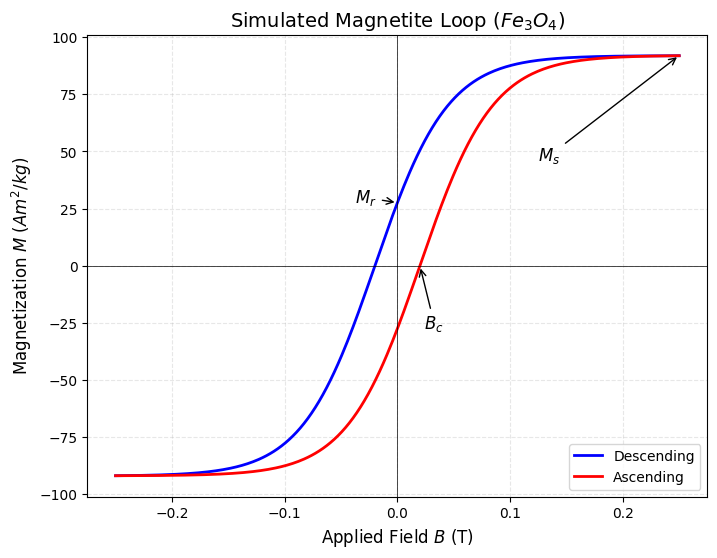

In [44]:
# Plotting a standard Magnetite loop
# Ms = 92 Am^2/kg (Standard)
# Bc = 0.02 T (20 mT, typical for Multi-Domain grains)
# Mr/Ms = 0.1 (intermediate squareness)

plot_takacs_hysteresis(Ms=92, Bc=0.02, Mr_Ms_ratio=0.3, field_range=0.25,
                       title="Simulated Magnetite Loop ($Fe_3O_4$)")

### Exercise: Contrasting Saturation and Coercivity

We will first compare **simulated** loops for **Magnetite** and **Hematite** side-by-side

**Pay attention to the axes!**
* **Magnetite (Left):** Strong magnetization ($M_s \approx 92\ Am^2/kg$), but a narrow loop (low $B_c$).
* **Hematite (Right):** Weak magnetization ($M_s \approx 0.4\ Am^2/kg$), but a broad loop (high $B_c$).

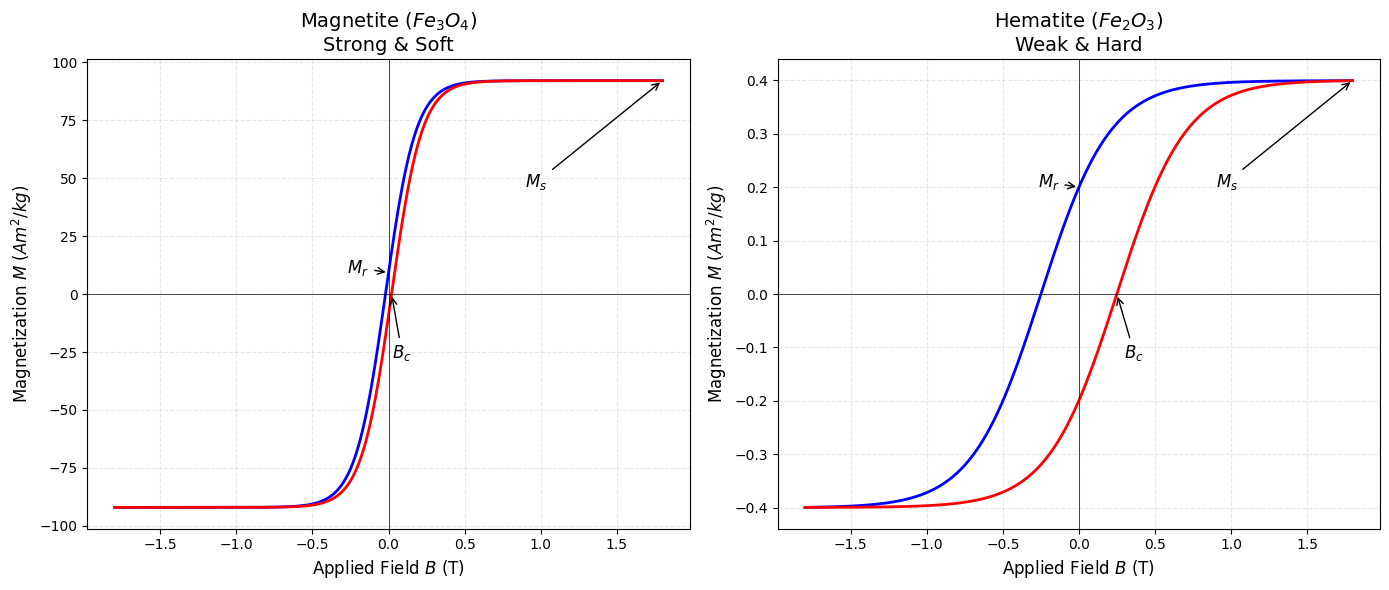

In [33]:
# Create a figure with 2 subplots (side-by-side)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# 1. Magnetite (Soft & Strong)
plot_takacs_hysteresis(Ms=92, Bc=0.02, Mr_Ms_ratio=0.1, field_range=1.8, ax=ax1,
                       title="Magnetite ($Fe_3O_4$)\nStrong & Soft")

# 2. Hematite (Hard & Weak)
plot_takacs_hysteresis(Ms=0.4, Bc=0.25, Mr_Ms_ratio=0.5, field_range=1.8, ax=ax2,
                       title="Hematite ($Fe_2O_3$)\nWeak & Hard")

plt.tight_layout()
plt.show()

### Exercise: Domain State (MD vs SD)

Now we examine how **domain state**, which in natural magnetite is strongly related to
grain size, affects the hysteresis loop. Here we compare two idealized end-members:
a multidomain-like (“soft”) loop and a single-domain-like (“hard”) loop for magnetite.

* **Multidomain (MD-like):** Large-grain behavior. Magnetization changes mainly by
  domain-wall motion, which is energetically easy. This leads to low remanence and low
  squareness (often $M_r/M_s \lesssim 0.1$).

* **Single-domain (SD-like):** Very small-grain behavior. Magnetization changes by
  coherent rotation rather than wall motion, producing higher coercivity and higher
  remanence. For randomly oriented uniaxial SD grains, a typical value is
  $M_r/M_s \approx 0.5$.

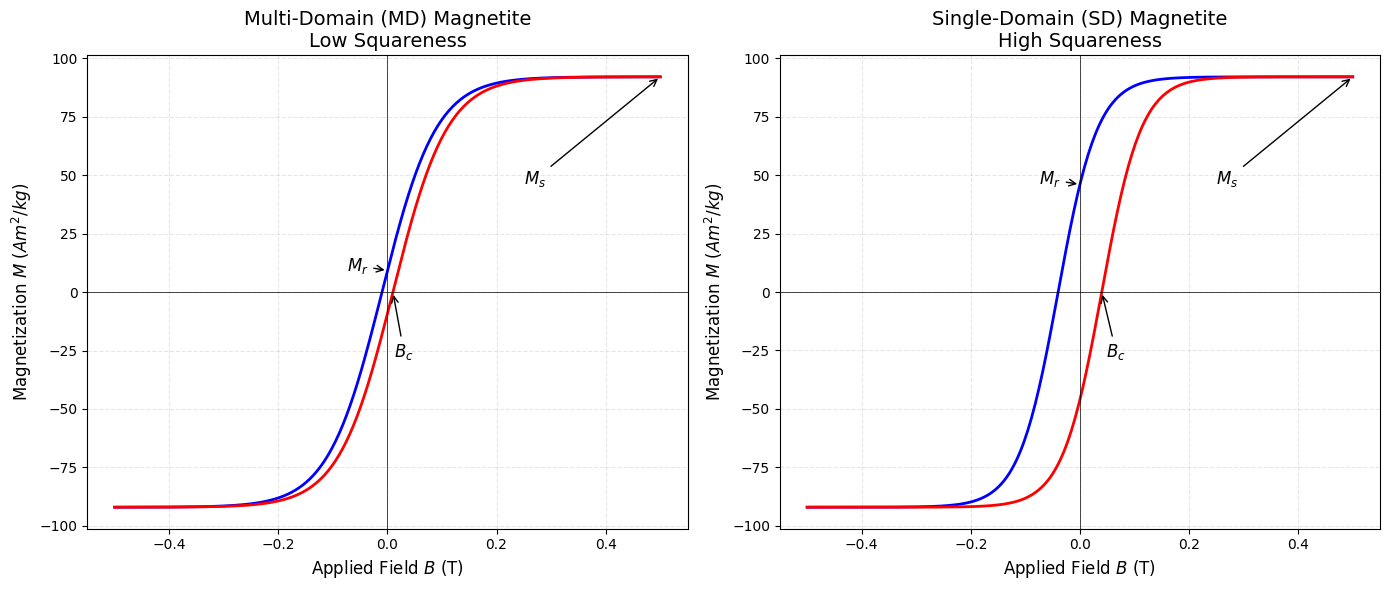

In [50]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

plot_takacs_hysteresis(Ms=92, Bc=0.01, Mr_Ms_ratio=0.1, field_range=0.5, ax=ax1,
                       title="Multi-Domain (MD) Magnetite\nLow Squareness")

plot_takacs_hysteresis(Ms=92, Bc=0.04, Mr_Ms_ratio=0.5, field_range=0.5, ax=ax2,
                       title="Single-Domain (SD) Magnetite\nHigh Squareness")

plt.tight_layout()
plt.show()

#### Important Note on Shape: Domain State vs. Mixtures

* **Squareness ($M_r/M_s$):** The ratio of remanent to saturation magnetization reflects how efficiently magnetic moments remain aligned after an applied field is removed. It is influenced by magnetic domain state, grain shape, anisotropy, and interactions between grains.

  * **Single-domain (SD) grains** (tens of nanometers for magnetite) reverse by coherent rotation rather than domain-wall motion and therefore tend to have relatively high squareness (commonly $M_r/M_s \sim 0.5$ for randomly oriented uniaxial particles).
  * **Pseudo–single-domain (PSD) grains** (roughly $\sim 0.1$–$10\,\mu$m for magnetite) show intermediate behavior, with squareness between SD and multidomain values.
  * **Multidomain (MD) grains** (typically $\gtrsim 10\,\mu$m for magnetite) contain mobile domain walls that move easily, leading to low remanence and low squareness (often $M_r/M_s \lesssim 0.1$).

* **Wasp-waisted loops:** A loop that is narrow near the origin but wide at high fields. This usually indicates a mixture of components with different coercivities (for example, “soft” magnetite mixed with “hard” hematite).

### Exercise: Mixtures and "Wasp-Waisted" Loops

Real rocks are often mixtures. When we mix a **"Soft"** mineral (low $B_c$) with a **"Hard"** mineral (high $B_c$), the resulting loop can look pinched, or "wasp-waisted."

However, we face a physical scaling problem:
* **Magnetite:** Very strong ($M_s \approx 92\ Am^2/kg$).
* **Hematite:** Very weak ($M_s \approx 0.4\ Am^2/kg$).

Because Magnetite is $\sim 230 \times$ stronger, a 50/50 mixture would just look like a Magnetite loop; the Hematite signal would be invisible.

**The "Knob": Concentration**
To see a wasp-waisted loop where *both* components are visible, the rock must be dominated by Hematite. In the code below, we define the **Mass Fraction** of each mineral to simulate a rock that is mostly Hematite with a trace of Magnetite.

### Calculation function

First, let's define a helper function that calculates the hysteresis values for a single component without plotting them. This allows us to generate the data for each mineral separately and then sum them up.

In [54]:
def calculate_takacs_arrays(Ms, Bc, Mr_Ms_ratio, B_cycle):
    """
    Calculates the ascending and descending magnetization branches using the
    Takács (2001) phenomenological model.

    This helper function computes the raw magnetization arrays without plotting,
    allowing for the mathematical summation of multiple components (mixtures).

    Parameters
    ----------
    Ms : float
        Saturation Magnetization (Am^2/kg).
    Bc : float
        Coercivity in Tesla (T).
    Mr_Ms_ratio : float
        Squareness ratio (Mr/Ms), effectively determining the loop shape
        (0.1 ~ Multi-Domain, 0.5 ~ Single-Domain).
    B_cycle : array_like
        Array of applied magnetic field values in Tesla (T).

    Returns
    -------
    M_desc : ndarray
        Magnetization values for the descending (upper) branch.
    M_asc : ndarray
        Magnetization values for the ascending (lower) branch.
    """
    mu0 = 4 * np.pi * 1e-7
    H_cycle = B_cycle / mu0
    Hc_Am = Bc / mu0

    # Calculate smoothing factor 's' based on desired Squareness (Takács model)
    ratio_clean = np.clip(Mr_Ms_ratio, 0.01, 0.99)
    s = Hc_Am / np.arctanh(ratio_clean)

    # Normalize inputs
    x = H_cycle / s
    a0 = Hc_Am / s
    xm = (max(B_cycle) / mu0) / s

    # Calculate Loop Closure Correction (b1)
    b1 = (np.tanh(xm + a0) - np.tanh(xm - a0)) / 2

    # Calculate Branches
    # Descending (Upper) Branch
    M_desc = Ms * (np.tanh(x + a0) - b1)
    # Ascending (Lower) Branch
    M_asc = Ms * (np.tanh(x - a0) + b1)

    return M_desc, M_asc

### Simulating the Mixture

Now we use our helper function to model this specific scenario.

In the code below, we simulate a rock where **Hematite makes up 99.5% of the mass**. Even with only **0.5% Magnetite**, the strong magnetization of the soft fraction is sufficient to "pinch" the loop, creating the characteristic wasp-waisted shape .

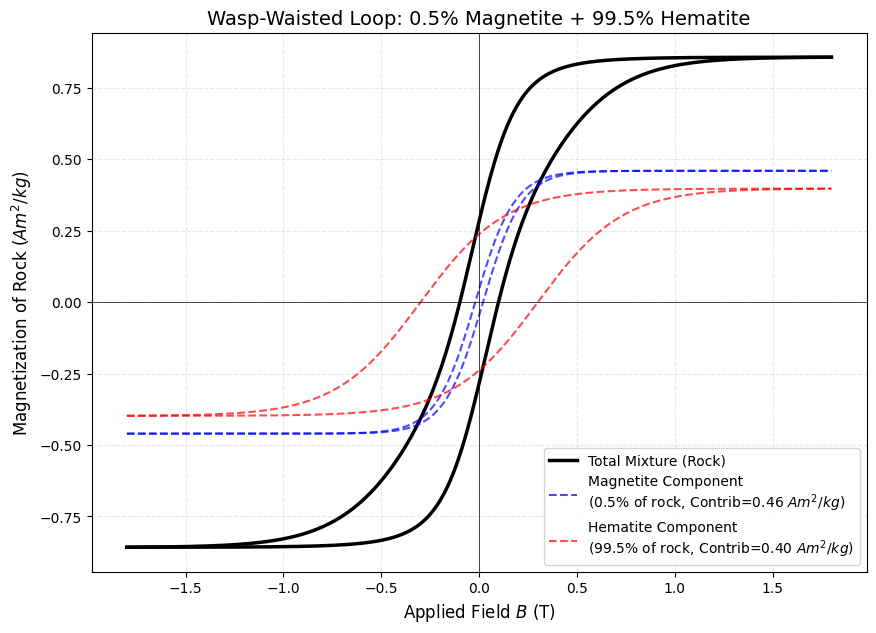

In [58]:
# 1. Setup Field
B_max = 1.8  # High field to saturate Hematite
B_cycle = np.linspace(-B_max, B_max, 500)

# 2. Intrinsic Properties (Fixed Constants)
Ms_Pure_Mag = 92.0  # Am^2/kg (Strong)
Bc_Mag = 0.02       # T (Soft)
Sq_Mag = 0.1        # MD

Ms_Pure_Hem = 0.4   # Am^2/kg (Weak)
Bc_Hem = 0.3        # T (Hard)
Sq_Hem = 0.6        # SD/Hard

# 3. The "Knob": Concentration (Mass Fraction)
# Note: A tiny amount of Magnetite (0.5%) rivals 99.5% Hematite
conc_mag = 0.005   # 0.5% Magnetite
conc_hem = 0.995   # 99.5% Hematite

# 4. Calculate Effective Ms per kg of Rock
Ms_eff_mag = Ms_Pure_Mag * conc_mag
Ms_eff_hem = Ms_Pure_Hem * conc_hem

# 5. Calculate Loop Components
M_desc_Mag, M_asc_Mag = calculate_takacs_arrays(Ms_eff_mag, Bc_Mag, Sq_Mag, B_cycle)
M_desc_Hem, M_asc_Hem = calculate_takacs_arrays(Ms_eff_hem, Bc_Hem, Sq_Hem, B_cycle)

# 6. Summation (The Mixture)
M_desc_Total = M_desc_Mag + M_desc_Hem
M_asc_Total = M_asc_Mag + M_asc_Hem

# 7. Plotting
plt.figure(figsize=(10, 7))

# Plot Total
plt.plot(B_cycle, M_desc_Total, 'k-', linewidth=2.5, label='Total Mixture (Rock)')
plt.plot(B_cycle, M_asc_Total, 'k-', linewidth=2.5)

# Plot Individual Components (Scaled by concentration)
plt.plot(B_cycle, M_desc_Mag, 'b--', alpha=0.7,
         label=f'Magnetite Component\n({conc_mag*100}% of rock, Contrib={Ms_eff_mag:.2f} $Am^2/kg$)')
plt.plot(B_cycle, M_asc_Mag, 'b--', alpha=0.7)

plt.plot(B_cycle, M_desc_Hem, 'r--', alpha=0.7,
         label=f'Hematite Component\n({conc_hem*100}% of rock, Contrib={Ms_eff_hem:.2f} $Am^2/kg$)')
plt.plot(B_cycle, M_asc_Hem, 'r--', alpha=0.7)

# Formatting
plt.axhline(0, color='k', linewidth=0.5)
plt.axvline(0, color='k', linewidth=0.5)
plt.grid(True, linestyle='--', alpha=0.3)
plt.title(f"Wasp-Waisted Loop: {conc_mag*100}% Magnetite + {conc_hem*100}% Hematite", fontsize=14)
plt.xlabel("Applied Field $B$ (T)", fontsize=12)
plt.ylabel("Magnetization of Rock ($Am^2/kg$)", fontsize=12)
plt.legend(loc='lower right', fontsize=10)

plt.show()

#### Reference
* Takács, J. (2001). A phenomenological mathematical model of hysteresis. *COMPEL: The International Journal for Computation and Mathematics in Electrical and Electronic Engineering*, 20(4), 1002-1014.